In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import sys

In [2]:
project_root = os.path.abspath("..")
sys.path.insert(0, project_root)

from tools.body_parts_map import keypoint_map  # noqa: E402

In [3]:
body_parts_map = {
    "head": [0, 1, 2, 3, 4],
    "left_arm": [5, 7, 9],
    "right_arm": [6, 8, 10],
    "torso": [5, 6, 11, 12],
    "left_hand": list(range(12, 34)),
    "right_hand": list(range(34, 55)),
}

face_parts_map = {
    "face_contour": list(range(0, 17)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(17, 22)) + list(range(36, 42)),
    "left_eye": list(range(22, 27)) + list(range(42, 48)),
    "mouth": list(range(48, 68)),
}

## Top 10% vs Bottom 10% Integrated Gradients

In [4]:
# Define the directory containing the JSON files
results_dir_top_10 = os.path.join(
    project_root,
    "gradient_saliency",
    "results",
    "integrated_gradients_top_10_face_body",
)

results_dir_bottom_10 = os.path.join(
    project_root,
    "gradient_saliency",
    "results",
    "integrated_gradients_bottom_10_face_body",
)

# Initialize variables to store cumulative saliency scores and counts
top_cumulative_face_saliency = None
top_cumulative_body_saliency = None
file_count = 0

bottom_cumulative_face_saliency = None
bottom_cumulative_body_saliency = None

# Iterate through all JSON files in the directory
for filename in os.listdir(results_dir_top_10):
    if filename.endswith(".json"):
        file_path = os.path.join(results_dir_top_10, filename)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract face and body saliency scores
        top_face_saliency = np.array(data["results"]["face_saliency"])
        top_body_saliency = np.array(data["results"]["body_saliency"])
        top_mix_saliency = np.array(data["results"]["mix_saliency"])

        # Initialize cumulative arrays if not already done
        if top_cumulative_face_saliency is None:
            top_cumulative_face_saliency = np.zeros_like(top_face_saliency)
        if top_cumulative_body_saliency is None:
            top_cumulative_body_saliency = np.zeros_like(top_body_saliency)
        if top_mix_saliency is None:
            top_mix_saliency = np.zeros_like(top_mix_saliency)

        # Accumulate saliency scores
        top_cumulative_face_saliency += top_face_saliency
        top_cumulative_body_saliency += top_body_saliency
        top_mix_saliency += top_mix_saliency
        file_count += 1

top_average_face_saliency = top_cumulative_face_saliency / file_count
top_average_body_saliency = top_cumulative_body_saliency / file_count
top_average_mix_saliency = top_mix_saliency / file_count

file_count = 0

for filename in os.listdir(results_dir_bottom_10):
    if filename.endswith(".json"):
        file_path = os.path.join(results_dir_bottom_10, filename)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract face and body saliency scores
        bottom_face_saliency = np.array(data["results"]["face_saliency"])
        bottom_body_saliency = np.array(data["results"]["body_saliency"])
        bottom_mix_saliency = np.array(data["results"]["mix_saliency"])

        # Initialize cumulative arrays if not already done
        if bottom_cumulative_face_saliency is None:
            bottom_cumulative_face_saliency = np.zeros_like(
                bottom_face_saliency
            )
        if bottom_cumulative_body_saliency is None:
            bottom_cumulative_body_saliency = np.zeros_like(
                bottom_body_saliency
            )

        # Accumulate saliency scores
        bottom_cumulative_face_saliency += bottom_face_saliency
        bottom_cumulative_body_saliency += bottom_body_saliency
        bottom_mix_saliency += bottom_mix_saliency
        file_count += 1

bottom_average_face_saliency = bottom_cumulative_face_saliency / file_count
bottom_average_body_saliency = bottom_cumulative_body_saliency / file_count
bottom_average_mix_saliency = bottom_mix_saliency / file_count

### Average analysis

In [5]:
print("Top mix saliency:", top_average_mix_saliency)
print("Bottom mix saliency:", bottom_average_mix_saliency)

Top mix saliency: 0.04671904886210406
Bottom mix saliency: 0.016821152634090848


In [6]:
face_keypoint_names = []
body_keypoint_names = []

face_start_index = 23
for i in range(len(top_average_face_saliency)):
    face_keypoint_names.append(keypoint_map[i + face_start_index])

lower_body_start_index = 13
for i in range(len(top_average_body_saliency)):
    index = i
    if index >= lower_body_start_index:
        index = (
            i
            + len(top_average_face_saliency)
            + face_start_index
            - lower_body_start_index
        )
    body_keypoint_names.append(keypoint_map[index])

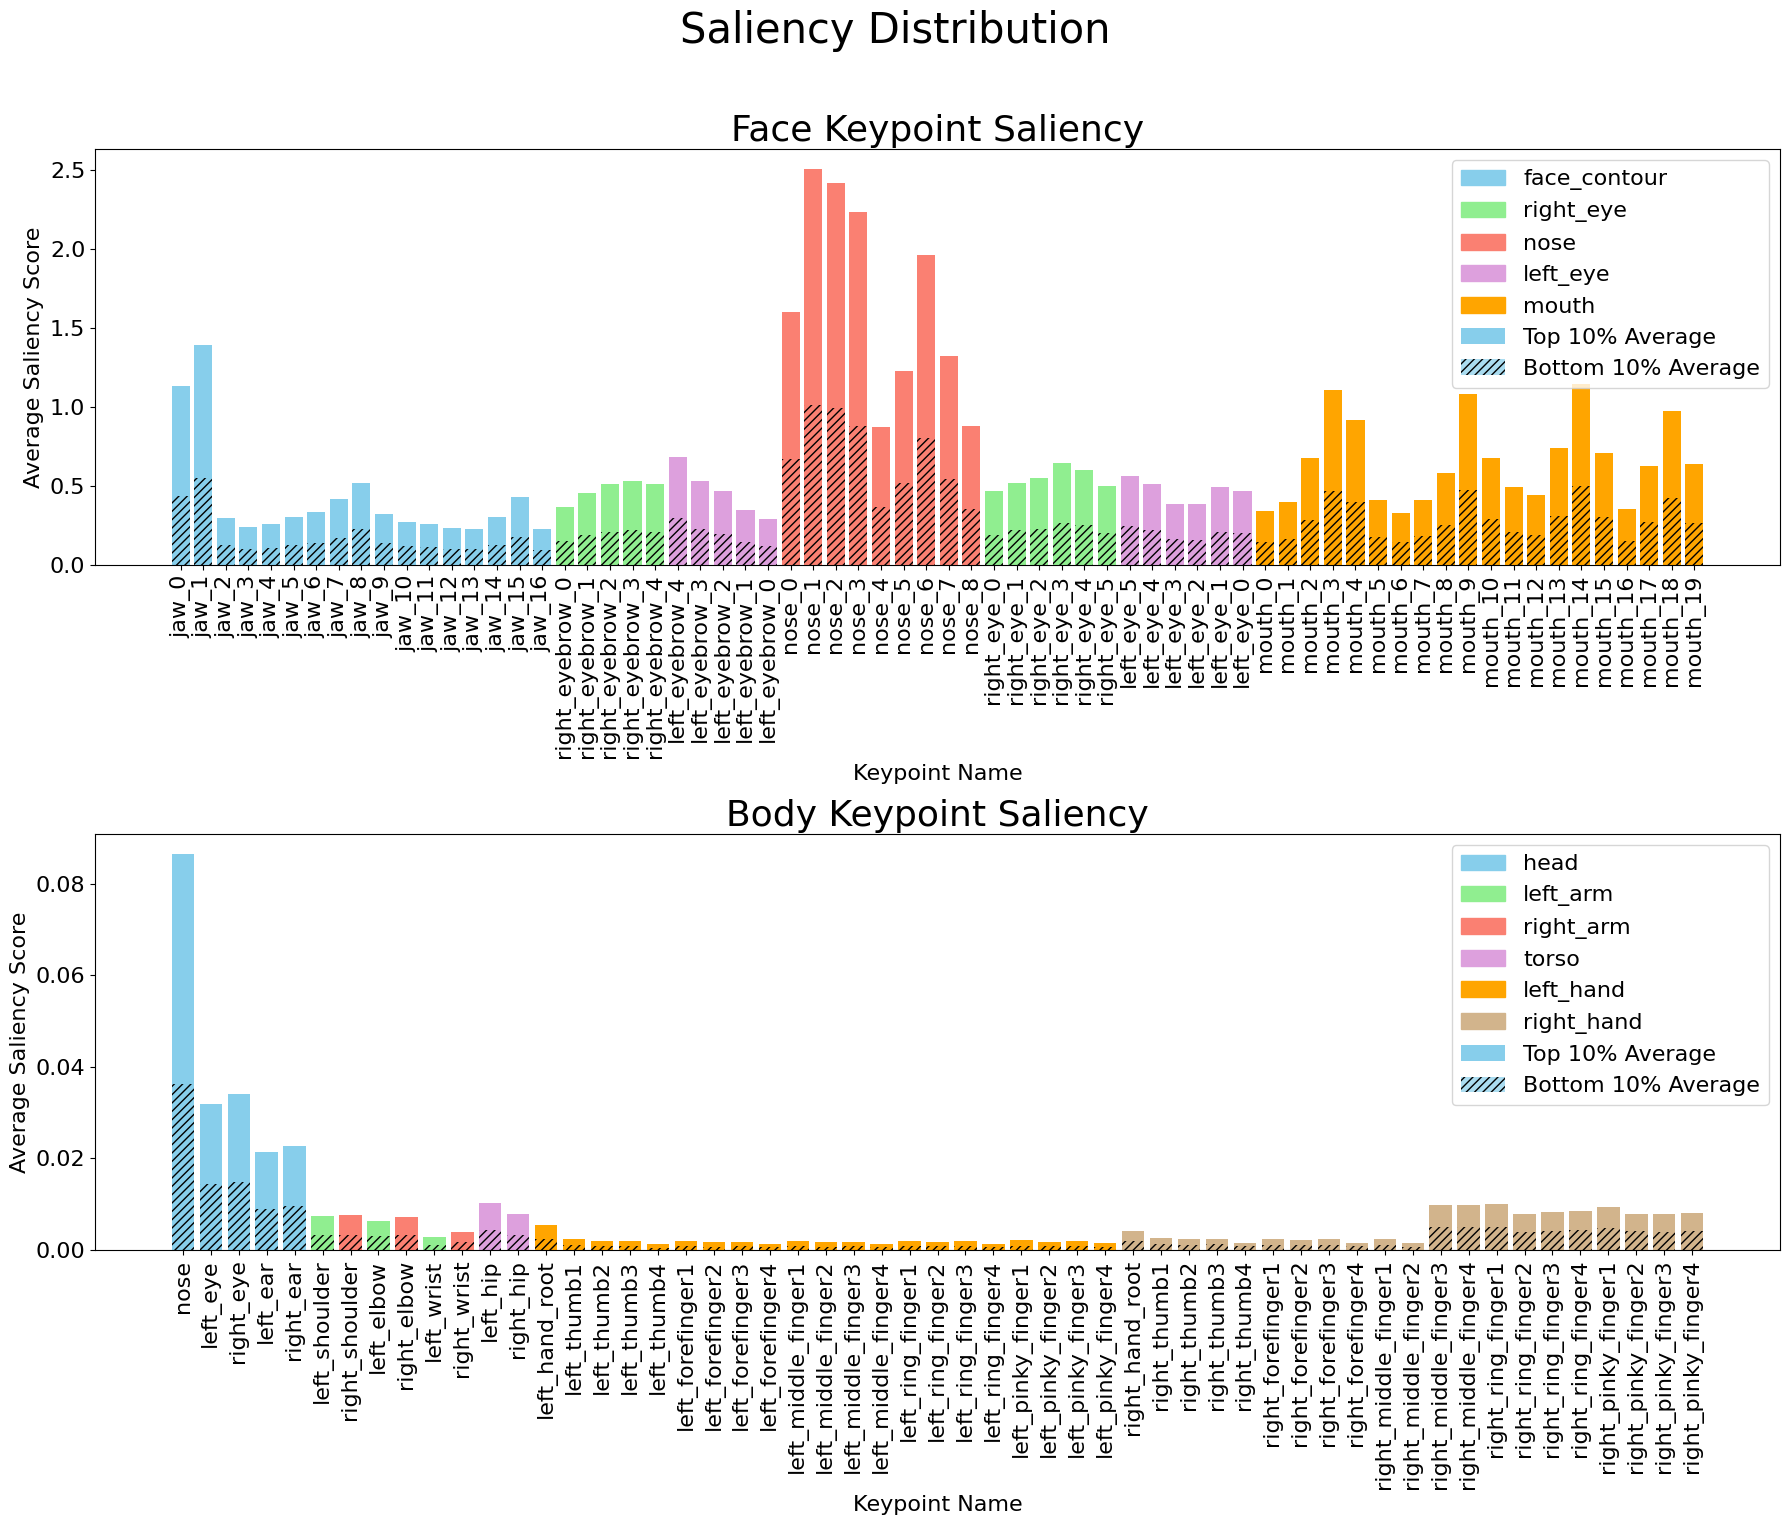

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(18, 16))
fig.suptitle("Saliency Distribution", fontsize=30)

# Define colors for different face parts
face_colors = {
    "face_contour": "skyblue",
    "right_eye": "lightgreen",
    "nose": "salmon",
    "left_eye": "plum",
    "mouth": "orange",
}

# Define colors for different body parts
body_colors = {
    "head": "skyblue",
    "left_arm": "lightgreen",
    "right_arm": "salmon",
    "torso": "plum",
    "left_hand": "orange",
    "right_hand": "tan",
}

# --- Plot 1: Face Keypoints ---
bar_colors_face = []
for i in range(len(top_average_face_saliency)):
    for part_name, indices in face_parts_map.items():
        if i in indices:
            bar_colors_face.append(face_colors[part_name])
            break

# Plot top average face saliency
bars_top_face = axes[0].bar(
    face_keypoint_names,
    top_average_face_saliency,
    color=bar_colors_face,
    label="Top 10% Average",
)

# Plot bottom average face saliency with hatching
bars_bottom_face = axes[0].bar(
    face_keypoint_names,
    bottom_average_face_saliency,
    color=bar_colors_face,
    hatch="////",
    alpha=0.7,
    label="Bottom 10% Average",
)

axes[0].set_title("Face Keypoint Saliency", fontsize=26)
axes[0].set_xlabel("Keypoint Name", fontsize=16)
axes[0].set_ylabel("Average Saliency Score", fontsize=16)
axes[0].tick_params(axis="x", rotation=90, labelsize=16)
axes[0].tick_params(axis="y", labelsize=16)

# Add legend for face parts
legend_elements_face = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=part)
    for part, color in face_colors.items()
]
axes[0].legend(
    handles=legend_elements_face + [bars_top_face, bars_bottom_face],
    loc="upper right",
    fontsize=16,
)

# --- Plot 2: Body Keypoints ---
bar_colors_body = []
for i in range(len(top_average_body_saliency)):
    for part_name, indices in body_parts_map.items():
        if i in indices:
            bar_colors_body.append(body_colors[part_name])
            break

# Plot top average body saliency
bars_top_body = axes[1].bar(
    body_keypoint_names,
    top_average_body_saliency,
    color=bar_colors_body,
    label="Top 10% Average",
)

# Plot bottom average body saliency with hatching
bars_bottom_body = axes[1].bar(
    body_keypoint_names,
    bottom_average_body_saliency,
    color=bar_colors_body,
    hatch="////",
    alpha=0.7,
    label="Bottom 10% Average",
)

axes[1].set_title("Body Keypoint Saliency", fontsize=26)
axes[1].set_xlabel("Keypoint Name", fontsize=16)
axes[1].set_ylabel("Average Saliency Score", fontsize=16)
axes[1].tick_params(axis="x", rotation=90, labelsize=16)
axes[1].tick_params(axis="y", labelsize=16)

# Add legend for body parts
legend_elements_body = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=part)
    for part, color in body_colors.items()
]
axes[1].legend(
    handles=legend_elements_body + [bars_top_body, bars_bottom_body],
    loc="upper right",
    fontsize=16,
)

# --- Display the plot ---
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [8]:
# Corrected face parts map based on dlib 68 points
face_parts_map_viz = {
    "face_contour": list(range(0, 17)),
    "right_eyebrow": list(range(17, 22)),
    "left_eyebrow": list(range(22, 27)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(36, 42)),
    "left_eye": list(range(42, 48)),
    "mouth": list(range(48, 68)),
}

# Corrected face colors to include eyebrows
face_colors_viz = {
    "face_contour": "skyblue",
    "right_eyebrow": "lightgreen",
    "left_eyebrow": "plum",
    "nose": "salmon",
    "right_eye": "lightgreen",
    "left_eye": "plum",
    "mouth": "orange",
}

x_coords = [
    9.53309692e02,
    9.54548950e02,
    9.56760986e02,
    9.58683655e02,
    9.60770996e02,
    9.64171692e02,
    9.68030762e02,
    9.74057495e02,
    9.84706482e02,
    9.96826599e02,
    1.00667865e03,
    1.01482703e03,
    1.02136145e03,
    1.02475610e03,
    1.02670862e03,
    1.02824890e03,
    1.02903064e03,
    9.53574463e02,
    9.56466736e02,
    9.60953003e02,
    9.65588684e02,
    9.70107117e02,
    9.90044495e02,
    9.95026306e02,
    1.00082202e03,
    1.00741144e03,
    1.01330688e03,
    9.80415649e02,
    9.79671265e02,
    9.78883911e02,
    9.78881958e02,
    9.75142822e02,
    9.77317810e02,
    9.80671204e02,
    9.84401855e02,
    9.87468201e02,
    9.60236877e02,
    9.62462158e02,
    9.67183533e02,
    9.71929993e02,
    9.67756348e02,
    9.63130066e02,
    9.92299561e02,
    9.96340698e02,
    1.00110101e03,
    1.00567871e03,
    1.00141473e03,
    9.96181274e02,
    9.70292175e02,
    9.73320679e02,
    9.77831360e02,
    9.80669128e02,
    9.83602783e02,
    9.89638184e02,
    9.95051636e02,
    9.89803345e02,
    9.85600342e02,
    9.81387329e02,
    9.77390991e02,
    9.74046021e02,
    9.71515015e02,
    9.77758667e02,
    9.81116211e02,
    9.84933716e02,
    9.94040466e02,
    9.84866272e02,
    9.81232361e02,
    9.77822815e02,
]

y_coords = [
    6.27681396e02,
    6.37936584e02,
    6.47280457e02,
    6.55990601e02,
    6.66087524e02,
    6.75589355e02,
    6.83066345e02,
    6.89605530e02,
    6.93360413e02,
    6.90424255e02,
    6.84714600e02,
    6.77841614e02,
    6.68785400e02,
    6.58901123e02,
    6.50303955e02,
    6.41177002e02,
    6.31009033e02,
    6.26440186e02,
    6.24776855e02,
    6.25130615e02,
    6.26449768e02,
    6.28179565e02,
    6.28934326e02,
    6.27492920e02,
    6.26555786e02,
    6.26684204e02,
    6.28952148e02,
    6.39802612e02,
    6.47265991e02,
    6.54425415e02,
    6.59756104e02,
    6.61216675e02,
    6.62293945e02,
    6.63274963e02,
    6.62601440e02,
    6.61728027e02,
    6.35295593e02,
    6.34618652e02,
    6.34935608e02,
    6.37044861e02,
    6.38269958e02,
    6.37831360e02,
    6.37902893e02,
    6.36111572e02,
    6.36421143e02,
    6.37352844e02,
    6.39433716e02,
    6.39456116e02,
    6.71838928e02,
    6.70561707e02,
    6.69273254e02,
    6.69978577e02,
    6.69562988e02,
    6.71253723e02,
    6.72972717e02,
    6.76383423e02,
    6.78456299e02,
    6.78723877e02,
    6.78078430e02,
    6.75664856e02,
    6.71775330e02,
    6.72169250e02,
    6.72374268e02,
    6.72526184e02,
    6.72795532e02,
    6.74144653e02,
    6.74283936e02,
    6.73762817e02,
]

dlib_face_keypoint_coords = list(zip(x_coords, y_coords))

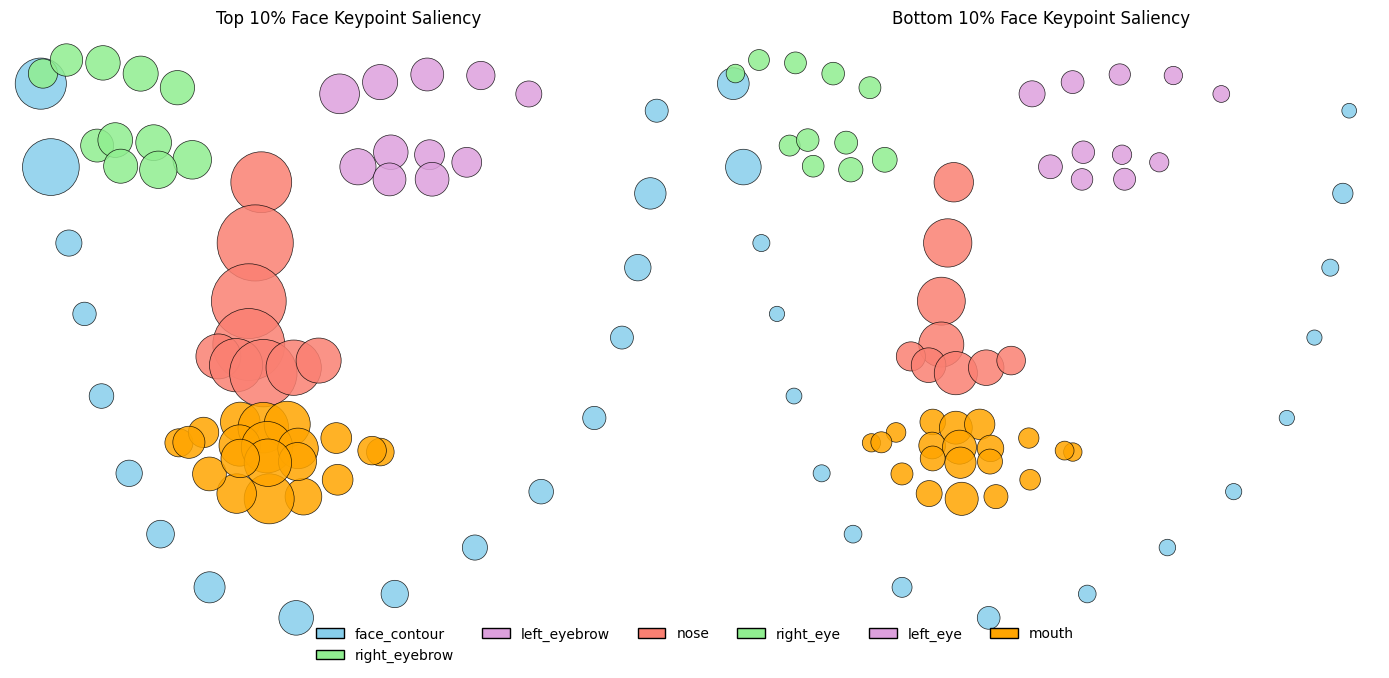

In [9]:
from matplotlib.patches import Patch

# Side-by-side visualization of Top vs Bottom face keypoint saliencies

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
for ax in axs:
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.axis("off")


# Reuse face_parts_map_viz & face_colors_viz already defined
# Build a color list per keypoint based on part membership
def part_colors():
    colors = []
    for kp_idx in range(len(x_coords)):
        assigned = None
        for part, indices in face_parts_map_viz.items():
            if kp_idx in indices:
                assigned = face_colors_viz.get(part, "gray")
                break
        colors.append(assigned or "gray")
    return colors


colors = part_colors()

# Common size scaling
size_scale = 1200
top_sizes = top_average_face_saliency * size_scale
bottom_sizes = bottom_average_face_saliency * size_scale

# Plot Top
axs[0].scatter(
    x_coords,
    y_coords,
    s=top_sizes,
    c=colors,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
)
axs[0].set_title("Top 10% Face Keypoint Saliency")

# Plot Bottom
axs[1].scatter(
    x_coords,
    y_coords,
    s=bottom_sizes,
    c=colors,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
)
axs[1].set_title("Bottom 10% Face Keypoint Saliency")

# Legend for parts
legend_handles = [
    Patch(facecolor=col, edgecolor="black", label=part)
    for part, col in face_colors_viz.items()
]
fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=min(len(legend_handles), 6),
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.02),
)

plt.tight_layout()
plt.show()

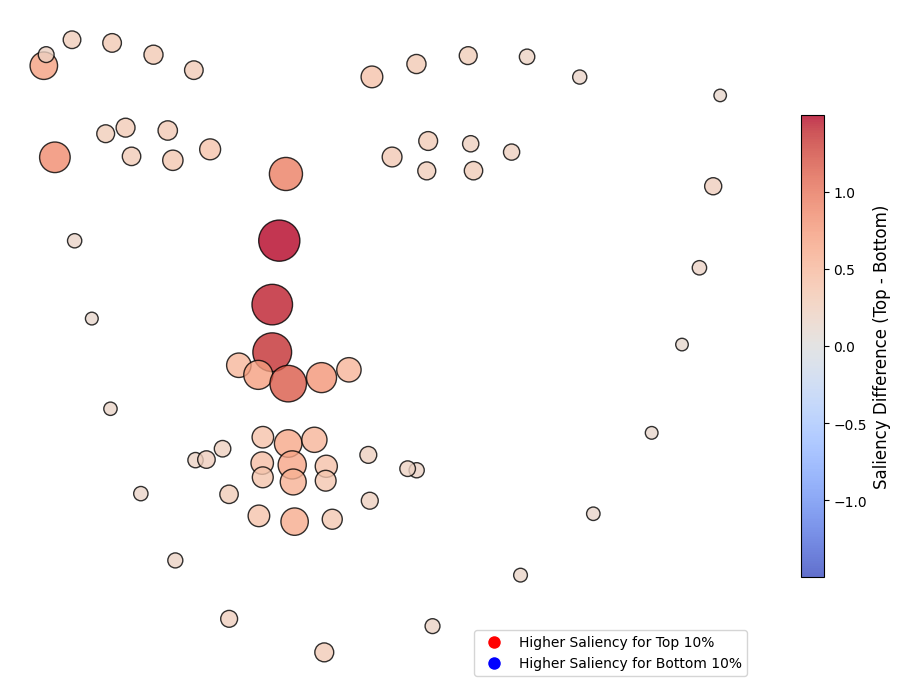

In [10]:
# Visualize face keypoints comparing top and bottom saliencies
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_alpha(0)  # Make the figure background transparent
ax.set_aspect("equal")
ax.invert_yaxis()  # Invert y-axis to match image coordinates
ax.axis("off")

# Corrected face parts map based on dlib 68 points
face_parts_map_viz = {
    "face_contour": list(range(0, 17)),
    "right_eyebrow": list(range(17, 22)),
    "left_eyebrow": list(range(22, 27)),
    "nose": list(range(27, 36)),
    "right_eye": list(range(36, 42)),
    "left_eye": list(range(42, 48)),
    "mouth": list(range(48, 68)),
}

# Calculate the difference and average saliency
saliency_diff = top_average_face_saliency - bottom_average_face_saliency
average_saliency = (
    top_average_face_saliency + bottom_average_face_saliency
) / 2

# Determine the range for the colormap
vmax = np.abs(saliency_diff).max()
vmin = -vmax

# Plot each keypoint
# Color indicates which saliency is higher (red for top, blue for bottom)
# Size indicates the average saliency of the keypoint
scatter = ax.scatter(
    x_coords,
    y_coords,
    s=average_saliency * 500,  # Scale size by average saliency
    c=saliency_diff,  # Color by the difference
    cmap="coolwarm",  # Use a diverging colormap
    vmin=vmin,
    vmax=vmax,
    alpha=0.8,
    edgecolor="black",
)

# Create a colorbar to act as a legend for the saliency difference
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Saliency Difference (Top - Bottom)", fontsize=12)

# Add a legend for what the colors mean
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Higher Saliency for Top 10%",
        markerfacecolor="red",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Higher Saliency for Bottom 10%",
        markerfacecolor="blue",
        markersize=10,
    ),
]
ax.legend(handles=legend_elements, loc="lower right", fontsize=10)

plt.show()

In [11]:
# Original body keypoints data (133 points)
body_keypoints_original = np.array(
    [
        [979.9771, 656.0691],
        [999.7747, 639.09973],
        [965.836, 636.27155],
        [1033.7134, 639.09973],
        [951.6949, 635.3288],
        [1087.4497, 732.43115],
        [889.47394, 718.29004],
        [1120.4456, 871.9569],
        [863.07715, 835.19],
        [1039.3699, 869.12866],
        [840.45135, 887.9835],
        [1020.515, 921.9222],
        [907.38605, 913.4375],
        [1140.2432, 953.03265],
        [781.05865, 971.8875],
        [897.9586, 1010.5399],
        [976.2062, 1016.19635],
        [845.1651, 1032.2229],
        [850.82153, 1047.3068],
        [866.84814, 1021.8528],
        [1020.515, 1018.08185],
        [1046.9117, 1042.5931],
        [991.29004, 1026.5665],
        [950.75214, 628.7296],
        [950.75214, 639.09973],
        [951.6949, 648.52716],
        [953.5804, 657.9546],
        [955.4658, 667.382],
        [959.2368, 676.8094],
        [963.9505, 684.3513],
        [971.49243, 690.95056],
        [981.8626, 693.77875],
        [993.1755, 691.89325],
        [1004.4884, 686.2368],
        [1012.9731, 679.63763],
        [1019.57227, 672.0957],
        [1024.286, 662.6683],
        [1027.1143, 652.29816],
        [1028.9996, 642.8707],
        [1029.9424, 632.50055],
        [954.5231, 624.01587],
        [958.29407, 623.0732],
        [963.00775, 624.01587],
        [967.7215, 624.9586],
        [972.4352, 626.8441],
        [990.3473, 628.7296],
        [995.061, 626.8441],
        [1001.66016, 625.90137],
        [1008.25934, 626.8441],
        [1013.91583, 628.7296],
        [980.91986, 638.15704],
        [979.9771, 644.7562],
        [979.03436, 651.3554],
        [978.0916, 657.01184],
        [973.3779, 660.78284],
        [976.2062, 661.7255],
        [979.9771, 662.6683],
        [983.7481, 661.7255],
        [987.51904, 660.78284],
        [959.2368, 635.3288],
        [963.9505, 634.38605],
        [967.7215, 634.38605],
        [972.4352, 636.27155],
        [967.7215, 638.15704],
        [963.00775, 637.2143],
        [992.2328, 638.15704],
        [996.9465, 636.27155],
        [1001.66016, 637.2143],
        [1006.3739, 638.15704],
        [1001.66016, 640.0425],
        [996.9465, 640.0425],
        [966.77875, 671.15295],
        [971.49243, 670.2102],
        [977.1489, 669.26746],
        [979.9771, 670.2102],
        [982.80536, 670.2102],
        [989.40454, 671.15295],
        [996.0037, 673.03845],
        [989.40454, 676.8094],
        [984.69086, 678.6949],
        [979.03436, 678.6949],
        [974.3207, 677.75214],
        [970.5497, 674.92395],
        [967.7215, 671.15295],
        [975.2634, 672.0957],
        [979.9771, 673.03845],
        [984.69086, 673.03845],
        [995.061, 673.03845],
        [984.69086, 673.9812],
        [979.9771, 673.9812],
        [975.2634, 673.03845],
        [1034.6561, 869.12866],
        [1021.45776, 856.87305],
        [1002.6029, 850.27386],
        [986.5763, 850.27386],
        [972.4352, 851.2166],
        [1004.4884, 862.5295],
        [988.4618, 871.9569],
        [981.8626, 874.7851],
        [974.3207, 878.5561],
        [1007.31665, 874.7851],
        [992.2328, 882.327],
        [984.69086, 884.2125],
        [978.0916, 883.2698],
        [1009.2021, 884.2125],
        [996.9465, 889.86896],
        [991.29004, 890.8117],
        [983.7481, 891.75446],
        [1011.0876, 890.8117],
        [1001.66016, 894.5827],
        [996.0037, 894.5827],
        [991.29004, 895.52545],
        [836.6804, 890.8117],
        [847.0506, 898.35364],
        [854.5925, 912.4948],
        [854.5925, 923.8077],
        [852.70703, 933.2351],
        [831.96674, 921.9222],
        [824.4248, 932.29236],
        [819.71106, 941.7198],
        [813.1119, 950.20447],
        [820.6538, 921.9222],
        [812.1691, 932.29236],
        [808.3982, 942.66254],
        [802.7417, 951.14716],
        [813.1119, 922.8649],
        [805.56995, 931.3496],
        [800.85626, 938.89154],
        [797.08527, 947.3762],
        [808.3982, 922.8649],
        [800.85626, 929.4641],
        [796.1425, 934.17786],
        [790.4861, 938.89154],
    ]
)

# Indices to keep from the original 133 keypoints
indices_to_keep = (
    list(range(5)) + [5, 7, 9, 6, 8, 10, 11, 12] + list(range(91, 133))
)

# Filter the body keypoints to keep only the desired 55 points
body_keypoints = body_keypoints_original[indices_to_keep]

# Correct mapping for the 55 keypoints
body_parts_map_viz = {
    "head": list(range(0, 5)),
    "left_arm": [5, 6, 7],  # Indices are now 5, 6, 7 in the 55-point array
    "right_arm": [8, 9, 10],
    "torso": [5, 8, 11, 12],  # shoulders, hips
    "left_hand": list(range(13, 34)),
    "right_hand": list(range(34, 55)),
}


def _skeleton():
    # Skeleton connections for the 55-point model
    return [
        (0, 1),
        (1, 2),
        (0, 3),
        (0, 4),  # Head
        (5, 8),  # Connect shoulders
        (5, 6),
        (6, 7),  # Left Arm
        (8, 9),
        (9, 10),  # Right Arm
        (11, 12),  # Hips
        (5, 11),
        (8, 12),  # Torso connections
        # Left Hand
        (7, 13),  # Connect arm to hand
        (13, 14),
        (14, 15),
        (15, 16),
        (16, 17),
        (13, 18),
        (18, 19),
        (19, 20),
        (20, 21),
        (13, 22),
        (22, 23),
        (23, 24),
        (24, 25),
        (13, 26),
        (26, 27),
        (27, 28),
        (28, 29),
        (13, 30),
        (30, 31),
        (31, 32),
        (32, 33),
        # Right Hand
        (10, 34),  # Connect arm to hand
        (34, 35),
        (35, 36),
        (36, 37),
        (37, 38),
        (34, 39),
        (39, 40),
        (40, 41),
        (41, 42),
        (34, 43),
        (43, 44),
        (44, 45),
        (45, 46),
        (34, 47),
        (47, 48),
        (48, 49),
        (49, 50),
        (34, 51),
        (51, 52),
        (52, 53),
        (53, 54),
    ]


# Define colors for body parts
body_colors = {
    "head": "skyblue",
    "left_arm": "lightgreen",
    "right_arm": "salmon",
    "torso": "plum",
    "left_hand": "orange",
    "right_hand": "tan",
}

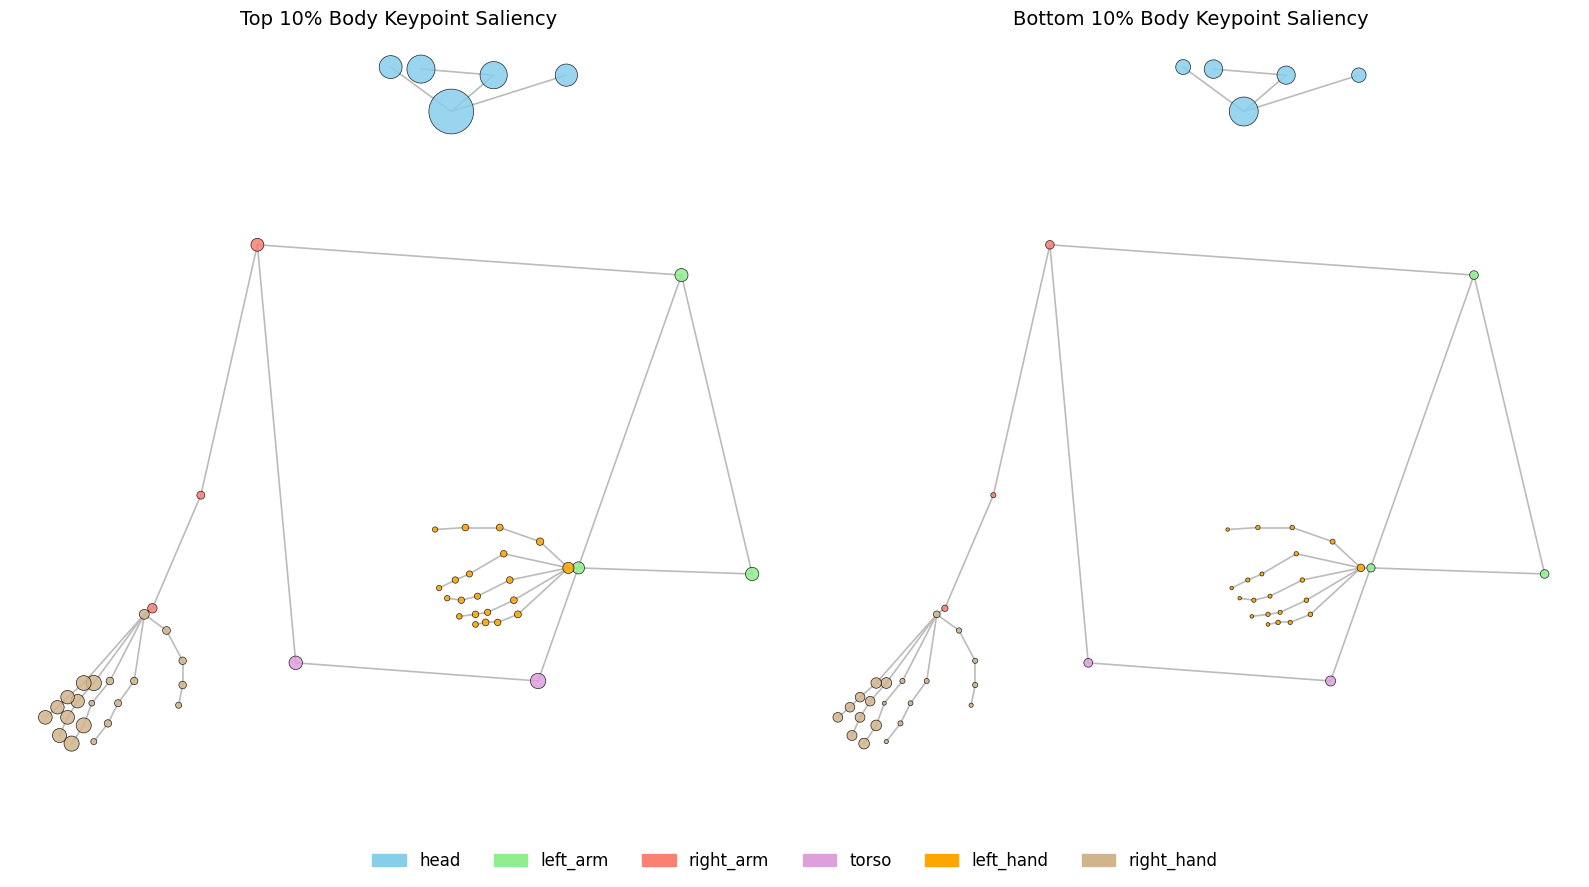

In [12]:
# Side-by-side visualization of Top vs Bottom body keypoint saliencies

fig, axs = plt.subplots(1, 2, figsize=(16, 10))
for ax in axs:
    ax.set_aspect("equal")
    ax.invert_yaxis()
    ax.axis("off")


# Build a color list per keypoint based on part membership
def body_part_colors():
    colors = []
    for kp_idx in range(len(body_keypoints)):
        assigned = None
        for part, indices in body_parts_map_viz.items():
            if kp_idx in indices:
                assigned = body_colors.get(part, "gray")
                break
        colors.append(assigned or "gray")
    return colors


body_colors_list = body_part_colors()

# Common size scaling
size_scale = 12000
top_sizes = top_average_body_saliency * size_scale
bottom_sizes = bottom_average_body_saliency * size_scale

# Draw skeleton underneath for both plots
for ax in axs:
    for p1, p2 in _skeleton():
        if p1 < len(body_keypoints) and p2 < len(body_keypoints):
            seg = body_keypoints[[p1, p2]]
            ax.plot(
                seg[:, 0], seg[:, 1], color="#bbbbbb", linewidth=1.2, zorder=1
            )

# Plot Top
axs[0].scatter(
    body_keypoints[:, 0],
    body_keypoints[:, 1],
    s=top_sizes,
    c=body_colors_list,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    zorder=3,
)
axs[0].set_title("Top 10% Body Keypoint Saliency", fontsize=14)

# Plot Bottom
axs[1].scatter(
    body_keypoints[:, 0],
    body_keypoints[:, 1],
    s=bottom_sizes,
    c=body_colors_list,
    edgecolor="black",
    linewidth=0.5,
    alpha=0.85,
    zorder=3,
)
axs[1].set_title("Bottom 10% Body Keypoint Saliency", fontsize=14)

# Legend for parts
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=part)
    for part, color in body_colors.items()
]
fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=min(len(legend_handles), 6),
    frameon=False,
    fontsize=12,
    bbox_to_anchor=(0.5, 0.02),
)

plt.tight_layout()
plt.show()

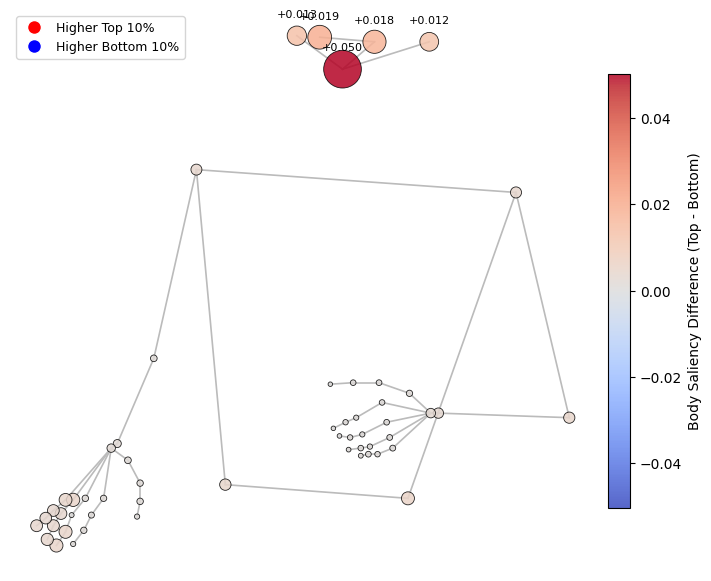

In [13]:
# Helper to flexibly fetch available arrays (average -> raw fallback)
def _fetch(name_options, fallback_len):
    for n in name_options:
        if n in globals():
            return np.asarray(globals()[n])
    return np.zeros(fallback_len)


saliency_diff = top_average_body_saliency - bottom_average_body_saliency
average_saliency = (
    top_average_body_saliency + bottom_average_body_saliency
) / 2.0

# Normalize sizes (avoid zeros blowing up / disappearing)
size_scale = 12000  # adjust if needed
sizes = np.clip(average_saliency, 0, None) * size_scale

# Diverging colormap centered at 0
vmax = np.abs(saliency_diff).max() if saliency_diff.size else 1.0
if vmax == 0:
    vmax = 1.0
vmin = -vmax

fig, ax = plt.subplots(figsize=(8, 10))
fig.patch.set_alpha(0)
ax.set_aspect("equal")
ax.invert_yaxis()
ax.axis("off")

# Draw skeleton underneath
for p1, p2 in _skeleton():
    if p1 < len(body_keypoints) and p2 < len(body_keypoints):
        seg = body_keypoints[[p1, p2]]
        ax.plot(seg[:, 0], seg[:, 1], color="#bbbbbb", linewidth=1.2, zorder=1)

# Scatter keypoints: color = diff (top - bottom), size = average
scatter = ax.scatter(
    body_keypoints[:, 0],
    body_keypoints[:, 1],
    c=saliency_diff,
    s=sizes,
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.85,
    zorder=3,
)

# Annotate top |diff| points (optional)
if len(body_keypoints) > 0:
    highlight_idx = np.argsort(np.abs(saliency_diff))[-5:]
    for j in highlight_idx:
        x, y = body_keypoints[j]
        ax.text(
            x,
            y - 10,
            f"{saliency_diff[j]:+.3f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            zorder=5,
        )

# Colorbar for difference
cbar = fig.colorbar(scatter, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Body Saliency Difference (Top - Bottom)")

# Legend for color meaning
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Higher Top 10%",
        markerfacecolor="red",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Higher Bottom 10%",
        markerfacecolor="blue",
        markersize=10,
    ),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=9, frameon=True)

plt.show()

In [11]:
top_body_part_ig_saliency = {
    part: np.mean(top_average_body_saliency[indices])
    for part, indices in body_parts_map.items()
}

bottom_body_part_ig_saliency = {
    part: np.mean(bottom_average_body_saliency[indices])
    for part, indices in body_parts_map.items()
}

top_face_part_ig_saliency = {
    part: np.mean(top_average_face_saliency[indices])
    for part, indices in face_parts_map.items()
}

bottom_face_part_ig_saliency = {
    part: np.mean(bottom_average_face_saliency[indices])
    for part, indices in face_parts_map.items()
}

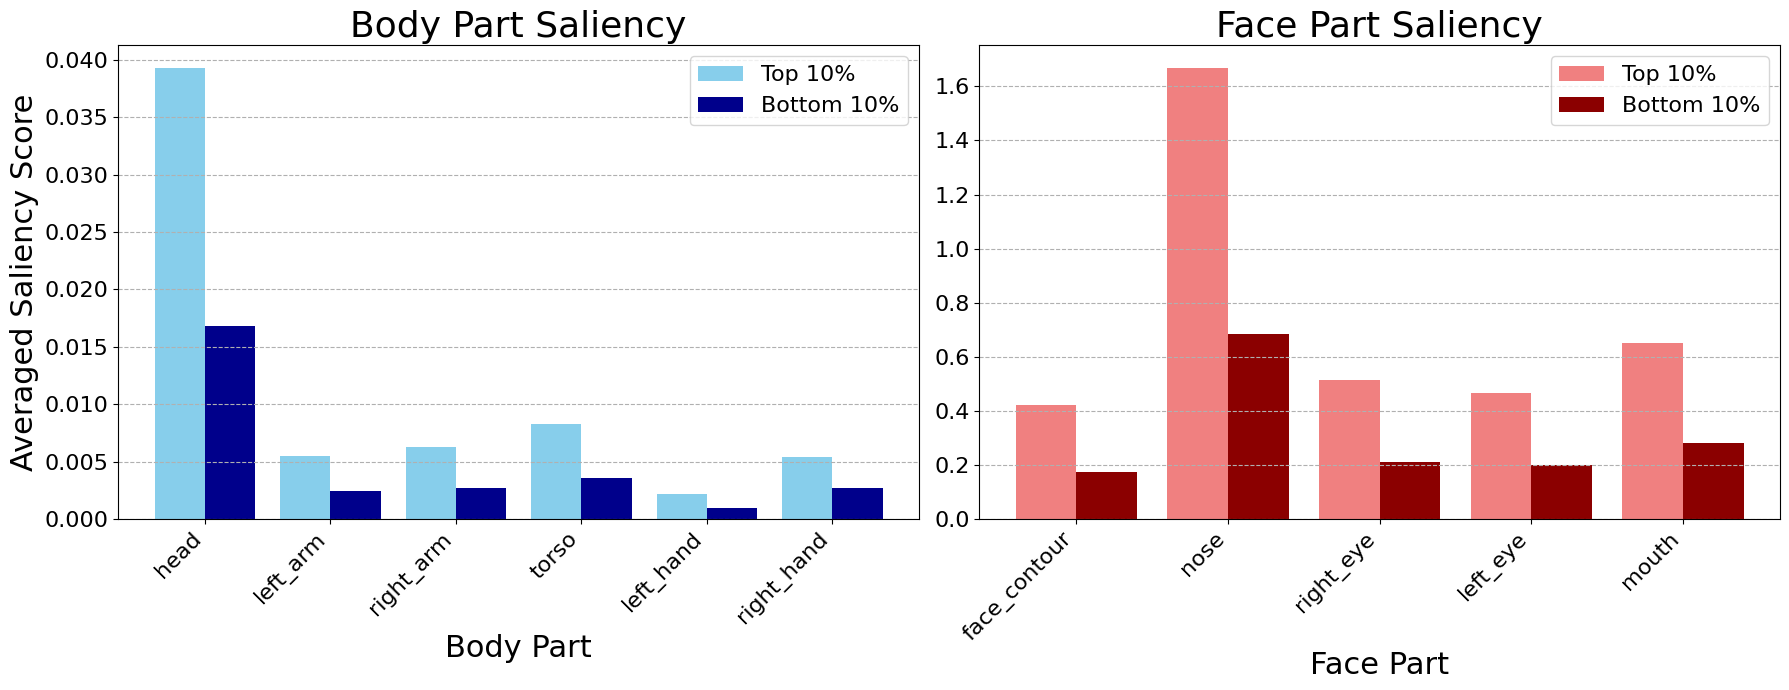

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Body Parts ---
x = np.arange(len(top_body_part_ig_saliency))  # X positions for the bars
width = 0.4  # Width of each bar

# Extract data for top and bottom saliencies
top_body_values = list(top_body_part_ig_saliency.values())
bottom_body_values = list(bottom_body_part_ig_saliency.values())
body_part_names = list(top_body_part_ig_saliency.keys())

# Plot top and bottom saliencies side by side
axes[0].bar(
    x - width / 2, top_body_values, width, label="Top 10%", color="skyblue"
)
axes[0].bar(
    x + width / 2,
    bottom_body_values,
    width,
    label="Bottom 10%",
    color="darkblue",
)

# Customize the plot
axes[0].set_title("Body Part Saliency", fontsize=26)
axes[0].set_xlabel("Body Part", fontsize=22)
axes[0].set_ylabel("Averaged Saliency Score", fontsize=22)
axes[0].set_xticks(x)
axes[0].set_xticklabels(body_part_names, rotation=45, ha="right", fontsize=16)
axes[0].tick_params(axis="y", labelsize=16)
axes[0].grid(axis="y", linestyle="--")
axes[0].legend(fontsize=16)

# --- Plot 2: Face Parts ---
x = np.arange(len(top_face_part_ig_saliency))  # X positions for the bars

# Extract data for top and bottom saliencies
top_face_values = list(top_face_part_ig_saliency.values())
bottom_face_values = list(bottom_face_part_ig_saliency.values())
face_part_names = list(top_face_part_ig_saliency.keys())

# Plot top and bottom saliencies side by side
axes[1].bar(
    x - width / 2, top_face_values, width, label="Top 10%", color="lightcoral"
)
axes[1].bar(
    x + width / 2,
    bottom_face_values,
    width,
    label="Bottom 10%",
    color="darkred",
)

# Customize the plot
axes[1].set_title("Face Part Saliency", fontsize=26)
axes[1].set_xlabel("Face Part", fontsize=22)
axes[1].set_xticks(x)
axes[1].set_xticklabels(face_part_names, rotation=45, ha="right", fontsize=16)
axes[1].tick_params(axis="y", labelsize=16)
axes[1].grid(axis="y", linestyle="--")
axes[1].legend(fontsize=16)

plt.tight_layout()
plt.show()